### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 23rd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [1]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [46]:
import numpy as np 
import scipy
from scipy.stats import uniform, norm, rv_histogram
from scipy import stats
import matplotlib.pyplot as plt
from scipy import optimize
import chainconsumer
import corner
import dynesty
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from astroML.density_estimation import KNeighborsDensity
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import preprocessing

# 1

In [3]:
data = np.load('../../../homeworks/hw_data/hw6_data_1.npy')

In [4]:
data.shape

(1000, 3)

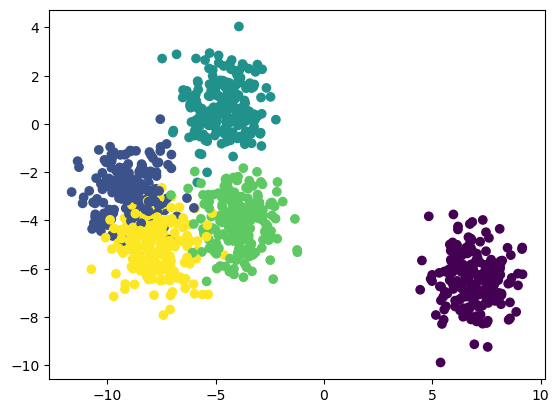

In [5]:
# LSS plotting the data with colors corresponding to their respective labels
plt.scatter(data[:, 0], data[:, 1], c=data[:, 2])

# 2 KDE 
* grid search 5 fold to find best bandwidth. test 30 bandwidths between 0.1 and 1.0
* plot the 2D kde estimate of the dist

In [6]:
bwidths = np.linspace(0.1, 1.0, 30)
 
# LSS from lecture 14 on KDE
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwidths}, cv=K) # Try each bandwidth with K-folds
grid.fit(data[:,:2]) 
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.4724137931034482


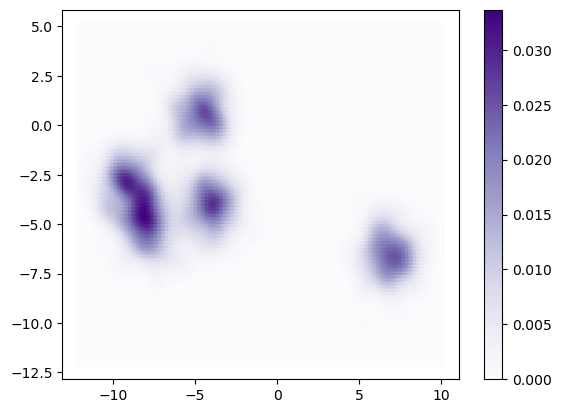

In [7]:
# LSS plotting!
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(data[:,:2])
u = np.linspace(-12, 10, 100) # LSS making mesh grid for x/y values
v = np.linspace(-12, 5, 100)
dgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(dgrid)) #evaluate the model on the grid

plt.scatter(dgrid[:,0], dgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()


# 3
* nearest neighbor density estimation

In [8]:
# LSS also from lecture 14
# Compute density with Bayesian nearest neighbors
k = 125 # LSS kneighbors ~100-150 looks close to the KDE. It fails to capture 
# LSS some of the fainter aspects of the distribution - see wispyness around left
# side clusters that is smoothed out by KNN method

nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(data[:,:2])
dens_nbrs = nbrs.eval(dgrid) / data.shape[0]

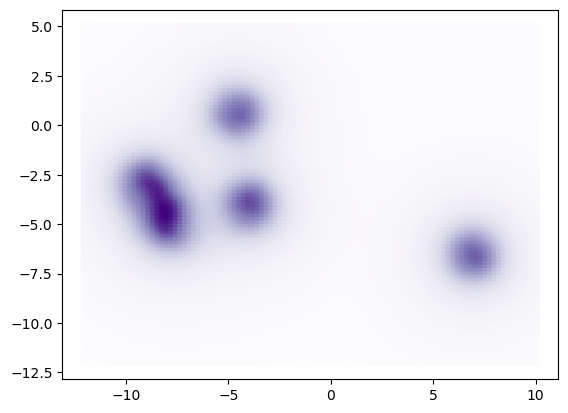

In [9]:
plt.scatter(dgrid[:,0], dgrid[:,1], c=dens_nbrs, 
            cmap="Purples", edgecolor="None")

* kneighbors ~100-150 looks close to the KDE. It fails to capture some of the 
fainter aspects of the distribution - see wispyness around left side clusters 
that is smoothed out by KNN method


# 4 GMM

In [24]:
# LSS more from Lecture 14

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(data[:,:2])

# compute the AIC and the BIC
AIC = [m.aic(data[:,:2]) for m in models]
BIC = [m.bic(data[:,:2]) for m in models]

optimal number of components according to BIC: GaussianMixture(n_components=4)


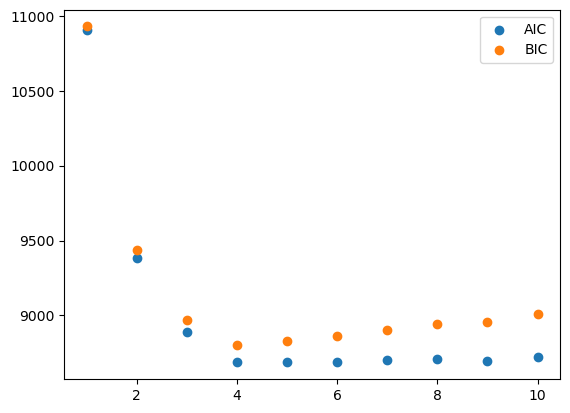

In [25]:
plt.scatter(N, AIC, label='AIC')
plt.scatter(N, BIC, label='BIC')
plt.legend()
M_best = models[np.argmin(BIC)]
print(f'optimal number of components according to BIC: {M_best}')

In [26]:
x = np.linspace(-6, 6, 1000)
x.reshape(-1,1)

array([[-6.        ],
       [-5.98798799],
       [-5.97597598],
       [-5.96396396],
       [-5.95195195],
       [-5.93993994],
       [-5.92792793],
       [-5.91591592],
       [-5.9039039 ],
       [-5.89189189],
       [-5.87987988],
       [-5.86786787],
       [-5.85585586],
       [-5.84384384],
       [-5.83183183],
       [-5.81981982],
       [-5.80780781],
       [-5.7957958 ],
       [-5.78378378],
       [-5.77177177],
       [-5.75975976],
       [-5.74774775],
       [-5.73573574],
       [-5.72372372],
       [-5.71171171],
       [-5.6996997 ],
       [-5.68768769],
       [-5.67567568],
       [-5.66366366],
       [-5.65165165],
       [-5.63963964],
       [-5.62762763],
       [-5.61561562],
       [-5.6036036 ],
       [-5.59159159],
       [-5.57957958],
       [-5.56756757],
       [-5.55555556],
       [-5.54354354],
       [-5.53153153],
       [-5.51951952],
       [-5.50750751],
       [-5.4954955 ],
       [-5.48348348],
       [-5.47147147],
       [-5

In [27]:
# LSS more from lecture 14

logprob = M_best.score_samples(dgrid)
responsibilities = M_best.predict_proba(dgrid)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

# x = np.linspace(-6, 6, 1000)
# logprob = M_best.score_samples(x.reshape(-1, 1))
# responsibilities = M_best.predict_proba(x.reshape(-1, 1))
# pdf = np.exp(logprob)
# pdf_individual = responsibilities * pdf[:, np.newaxis]

In [28]:
np.mean(pdf_individual, axis=0)

array([0.00053868, 0.00052388, 0.00103347, 0.00052376])

In [35]:
M_best.covariances_.shape

(4, 2, 2)

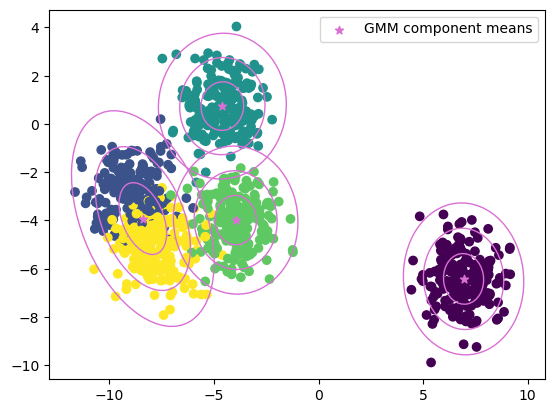

In [45]:
# LSS plotting
componentmeans = M_best.means_
componentcovar = M_best.covariances_


plt.scatter(data[:,0], data[:,1], c=data[:, 2])
plt.scatter(componentmeans[:,0], componentmeans[:,1], color='orchid', marker='*', label='GMM component means')
for i in range(4):
    draw_ellipse(mu=componentmeans[i, :], C=componentcovar[i, :, :], color='orchid', fill=False)

plt.legend()

# 5 KMeans

In [47]:
# LSS more from Lecture 14
# LSS making KMeans with 5 clusters

# Compute the KMeans clustering
n_clusters = 5
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(data[:,:2]))

/Users/levischult/miniconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5)

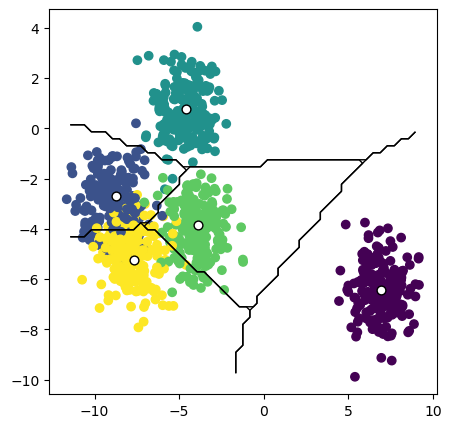

In [79]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(data[:,0], data[:,1], 50)

ax.scatter(data[:,0], data[:,1], c=data[:,2])

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H =  clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

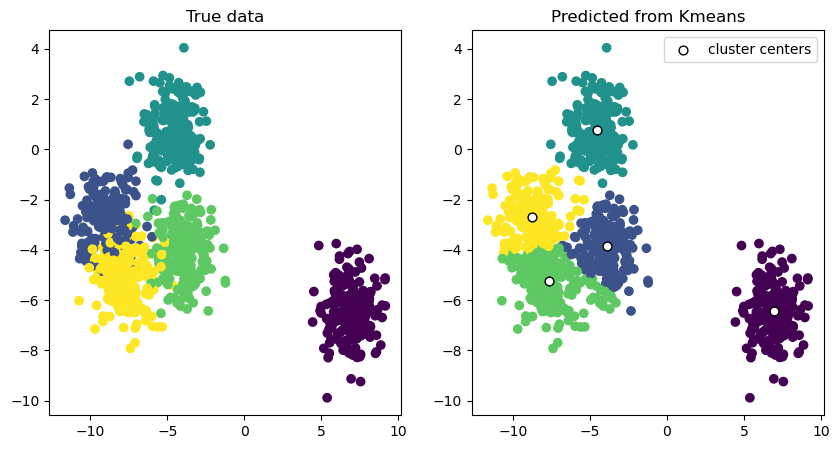

In [75]:
# LSS plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# LSS predicting data labels
H = clf.predict(scaler.fit_transform(data[:,:2]))

axes[0].scatter(data[:,0], data[:,1], c=data[:,2])
axes[0].set_title('True data')
axes[1].set_title('Predicted from Kmeans')
axes[1].scatter(data[:,0], data[:,1], c=H)
# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
axes[1].scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k', label='cluster centers')
plt.legend()
plt.show()


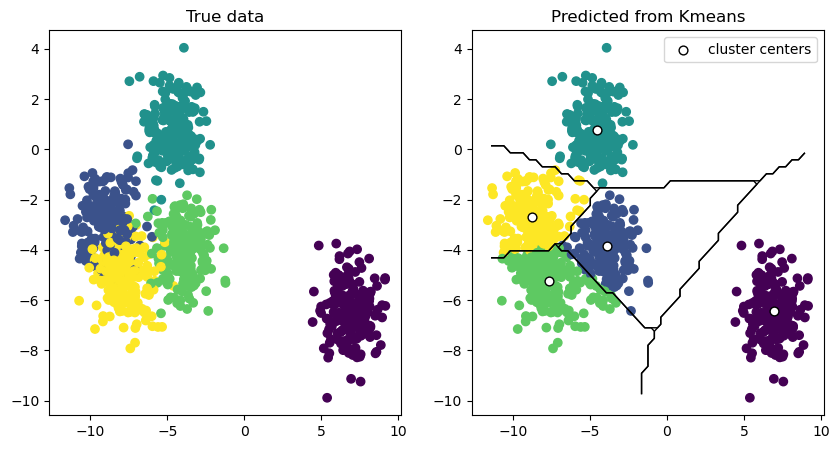

In [82]:
# LSS once more of the above this time with cluster boundaries
# LSS plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# LSS predicting data labels
H = clf.predict(scaler.fit_transform(data[:,:2]))

axes[0].scatter(data[:,0], data[:,1], c=data[:,2])
axes[0].set_title('True data')
axes[1].set_title('Predicted from Kmeans')
axes[1].scatter(data[:,0], data[:,1], c=H)
# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
axes[1].scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k', label='cluster centers')

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(data[:,0], data[:,1], 50)

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H =  clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    axes[1].contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

plt.legend()
plt.show()


SRT: Really excellent work, Levi! I particularly like the "tesselation" plot just above.